In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns 
import os
sns.set_theme(style="white")

### stats analysis imports 
import statsmodels.formula.api as smf

SEED = 125

In [2]:
def print_df_info(df, name):
    print(f"{name}")
    print(f"shape: {df.shape}")
    print(f"columns: {df.columns}")
    print()

# 0. Loading and pre-processing data for regression

In [6]:
persuasive_strategies_df = pd.read_csv("llm_responses_labeled.csv", index_col=0)
treatment_df = pd.read_csv("final_data_processed.csv", index_col = 0)

In [7]:
print_df_info(treatment_df, "treatment_df")
print("Number of unique treatment messages: ", treatment_df['treatment_message_id'].nunique())
treatment_df.head()

treatment_df
shape: (25982, 14)
columns: Index(['age', 'education', 'gender', 'party_affiliation', 'ideo_affiliation',
       'political_knowledge', 'issue', 'issue_full', 'treatment_message_id',
       'treatment_message', 'condition', 'model', 'dv_response_mean',
       'treatment_message_word_count'],
      dtype='object')

Number of unique treatment messages:  730


,age,education,gender,party_affiliation,ideo_affiliation,political_knowledge,issue,issue_full,treatment_message_id,treatment_message,condition,model,dv_response_mean,treatment_message_word_count
0,25,4-year college,Male,Strong Republican,Moderately liberal,2,assisted suicide,The U.S. should allow terminally ill patients ...,allow_terminally_ill_suicide_pythia-410m_3,"""For the sake of all humanity, I hereby procla...",AI,pythia-410m,100.00,49.0
1,52,Graduate degree,Male,Independent,Ideologically neutral,3,worker_pensions,The U.S. should transition pension plans for p...,transition_public_worker_pension_private_gpt-4...,The future of public workers in the United Sta...,AI,gpt-4-0125-preview,50.75,210.0
2,51,Technical certification or trade school,Male,Strong Republican,Moderately conservative,0,veteran healthcare,The U.S. should increase privatization of vete...,increase_veterans_healthcare_privatization_pyt...,Privatizing veteran healthcare is essential fo...,AI,pythia-1.4b,40.00,190.0
3,24,4-year college,Female,Moderate Republican,Moderately conservative,2,affirmative_action,The U.S. should not allow the use of affirmati...,allow_affirmative_action_Llama-2-70b-hf_1,Affirmative action programs were initially int...,AI,Llama-2-70b-hf,63.75,241.0
4,40,Graduate degree,Male,Independent,Very liberal,1,foreign_aid,The U.S. should not decrease foreign aid spending,decrease_foreign_aid_spending_Llama-2-70b-hf_1,Foreign aid is a crucial aspect to maintain pe...,AI,Llama-2-70b-hf,85.25,304.0


In [8]:
# for every row in treatment_df, take the entry `treatment_message` and find a match for it in persuasive_strategies_df['response']. If a match is found, copy over the persuasive strategies columns to treatment_df. 
# If no match is found, fill the persuasive strategies columns with NaN. 
# After this operation, treatment_df should have the same number of rows, but with additional columns for persuasive strategies.
merged_df = treatment_df.merge(persuasive_strategies_df, left_on='treatment_message', right_on='response', how='left')

# Print out the `treatment_message` values that did not find a match.
unmatched_subset = merged_df[merged_df['central'].isna()] 
print("Unmatched entries:", unmatched_subset['treatment_message'].unique())

# It appears that all of the unmatched entries are due to missing treatment messages (these are folks who expressed their position without receiving a treatment -- either from human or AI).
# We can fill in the persuasive strategy columns with 0 for these rows, since they received no persuasive strategies.
roles_with_notreatment = merged_df['treatment_message'].isna()
new_cols = ['attractiveness',
       'authority', 'central', 'forewarning', 'gainframe', 'lossframe',
       'partisan', 'partisanship', 'peripheral', 'refutation', 'religion',
       'repetition']
merged_df.loc[roles_with_notreatment, new_cols] = 0
# However, we should make a separate indicator for no treatment too. 
merged_df['no_treatment'] = 0 
merged_df.loc[roles_with_notreatment, 'no_treatment'] = 1

print_df_info(merged_df, "merged_df")
merged_df.head()    

Unmatched entries: [nan]
merged_df
shape: (25982, 29)
columns: Index(['age', 'education', 'gender', 'party_affiliation', 'ideo_affiliation',
       'political_knowledge', 'issue', 'issue_full', 'treatment_message_id',
       'treatment_message', 'condition', 'model', 'dv_response_mean',
       'treatment_message_word_count', 'issue_stance_full', 'response',
       'attractiveness', 'authority', 'central', 'forewarning', 'gainframe',
       'lossframe', 'partisan', 'partisanship', 'peripheral', 'refutation',
       'religion', 'repetition', 'no_treatment'],
      dtype='object')



,age,education,gender,party_affiliation,ideo_affiliation,political_knowledge,issue,issue_full,treatment_message_id,treatment_message,...,forewarning,gainframe,lossframe,partisan,partisanship,peripheral,refutation,religion,repetition,no_treatment
0,25,4-year college,Male,Strong Republican,Moderately liberal,2,assisted suicide,The U.S. should allow terminally ill patients ...,allow_terminally_ill_suicide_pythia-410m_3,"""For the sake of all humanity, I hereby procla...",...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,52,Graduate degree,Male,Independent,Ideologically neutral,3,worker_pensions,The U.S. should transition pension plans for p...,transition_public_worker_pension_private_gpt-4...,The future of public workers in the United Sta...,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0
2,51,Technical certification or trade school,Male,Strong Republican,Moderately conservative,0,veteran healthcare,The U.S. should increase privatization of vete...,increase_veterans_healthcare_privatization_pyt...,Privatizing veteran healthcare is essential fo...,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0
3,24,4-year college,Female,Moderate Republican,Moderately conservative,2,affirmative_action,The U.S. should not allow the use of affirmati...,allow_affirmative_action_Llama-2-70b-hf_1,Affirmative action programs were initially int...,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0
4,40,Graduate degree,Male,Independent,Very liberal,1,foreign_aid,The U.S. should not decrease foreign aid spending,decrease_foreign_aid_spending_Llama-2-70b-hf_1,Foreign aid is a crucial aspect to maintain pe...,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0


# 1. Effect of Persuasion Techniques on Persuasiveness

In this section, we supplement the original experiment dataset with variables that correspond to popular theories of "persuasive techniques". In particular, we use the `classify.py` script to call on a language model to classify whether each persuasive text (e.g. `treatment_message`) contains a particular strategy (e.g. `central` refers to a message "using reasons/evidence"). 

Note that the original study measures "persuasiveness" by taking some aggregation of `dv_response_mean` which measures how "aligned" a participant is with the stated issue position AFTER the treatment, and subtracting that from the control. In our use here, we do NOT aggregate because we want to understand how demographic features and persuasive strategies may contribute to "alignment". Control groups are distingushied by a custom one-hot encoded variable of `no_treatment`. 

In [6]:
X  = merged_df.drop(columns=['issue', 'issue_full', 'issue_stance_full', 'treatment_message_id', 'treatment_message', 
                             'partisan', 
                             'condition', 'model', 'dv_response_mean', 'response'])
y = merged_df['dv_response_mean']
print("Number of features: ", X.shape[1])
print("Number of samples: ", X.shape[0])
print("Feature columns: ", X.columns)

Number of features:  19
Number of samples:  25982
Feature columns:  Index(['age', 'education', 'gender', 'party_affiliation', 'ideo_affiliation',
       'political_knowledge', 'treatment_message_word_count', 'attractiveness',
       'authority', 'central', 'forewarning', 'gainframe', 'lossframe',
       'partisanship', 'peripheral', 'refutation', 'religion', 'repetition',
       'no_treatment'],
      dtype='object')


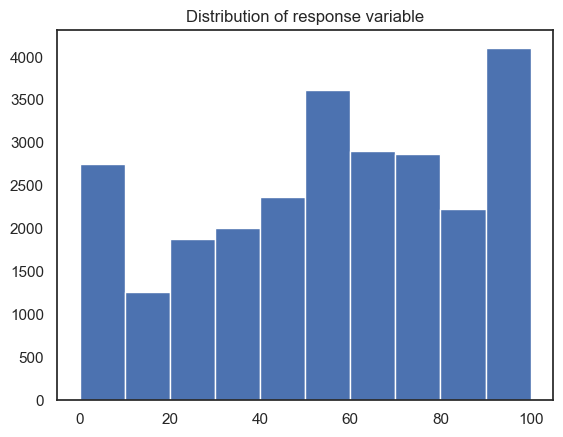

In [7]:
# what is the distribution of Y?
plt.hist(y)
plt.title("Distribution of response variable")
plt.show()

## 1.1 Naive regression on all covariates

In [8]:
import statsmodels.formula.api as smf

cols = list(merged_df.columns)
start_idx = cols.index("attractiveness")
cat_vars = cols[start_idx:]

formula = "dv_response_mean ~ age + C(education) + C(gender) + C(party_affiliation) + \
           C(ideo_affiliation) + political_knowledge + treatment_message_word_count + \
           " + " + ".join([f"C({c})" for c in cat_vars])

model = smf.ols(
    formula,
    data=merged_df
).fit(cov_type="HC3")   # robust SEs
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       dv_response_mean   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     14.12
Date:                Sat, 20 Sep 2025   Prob (F-statistic):           6.02e-77
Time:                        14:42:41   Log-Likelihood:                -99970.
No. Observations:               20819   AIC:                         2.000e+05
Df Residuals:                   20785   BIC:                         2.003e+05
Df Model:                          33                                         
Covariance Type:                  HC3                                         
                                                               coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------

/Users/kaihung/miniconda3/envs/llm/lib/python3.13/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 34, but rank is 33
  warnings.warn('covariance of constraints does not have full '


At this point, it is quite clear that many of the variables we have are deeply correlated (as expected).

## 1.2 Correlation Heatmap

In the next two sections, let us try to understand the correlations that exist visually and through the variance inflation factor. 

In [9]:
import patsy

# Use the exact formula string you built above
y, X = patsy.dmatrices(formula, data=merged_df, return_type="dataframe")

response = y.iloc[:, 0]         # dependent variable
X_expanded = X.drop(columns=["Intercept"], errors="ignore")  # predictors only
X_expanded.head()

,C(education)[T.4-year college],C(education)[T.Did not graduate high school],C(education)[T.Graduate degree],C(education)[T.High school diploma],C(education)[T.Technical certification or trade school],C(gender)[T.Male],C(gender)[T.Non-binary / third gender],C(gender)[T.Prefer not to say],C(party_affiliation)[T.Moderate Democrat],C(party_affiliation)[T.Moderate Republican],...,C(partisan)[T.1.0],C(partisanship)[T.1.0],C(peripheral)[T.1.0],C(refutation)[T.1.0],C(religion)[T.1.0],C(repetition)[T.1.0],C(no_treatment)[T.1],age,political_knowledge,treatment_message_word_count
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,2.0,49.0
1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,52.0,3.0,210.0
2,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,51.0,0.0,190.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,24.0,2.0,241.0
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,1.0,304.0


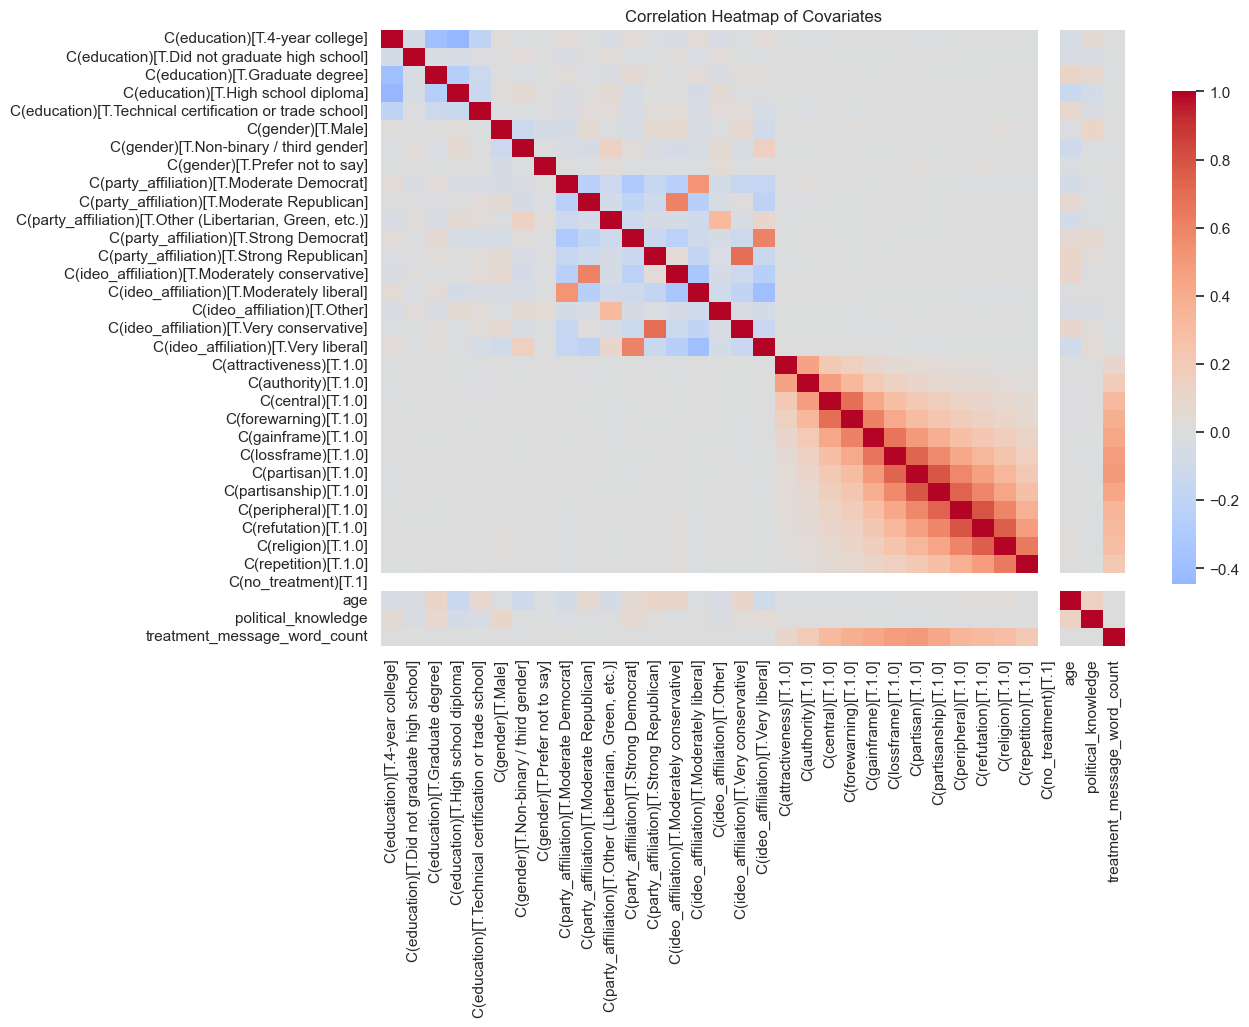

In [10]:
corr = X_expanded.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr, cmap="coolwarm", center=0, cbar_kws={"shrink": .8})
plt.title("Correlation Heatmap of Covariates")
plt.show()

## 1.3 Variance Inflation Factor (VIF) to detect collinear features! 

In [11]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_vif = X_expanded.assign(const=1) # add constant for VIF calculation

# Drop columns with perfect collinearity
X_vif_noint = X_vif.drop(columns=["const"], errors="ignore")
X_vif_noint = X_vif_noint.loc[:, X_vif_noint.std() > 0]  # drop constant/zero-variance cols


vif_data = pd.DataFrame({
    "variable": X_vif_noint.columns,
    "VIF": [variance_inflation_factor(X_vif_noint.values, i)
            for i in range(X_vif_noint.shape[1])]
})

vif_data.sort_values("VIF", ascending=False).head(15)


,variable,VIF
19,C(authority)[T.1.0],175.959349
18,C(attractiveness)[T.1.0],173.190295
20,C(central)[T.1.0],59.215300
21,C(forewarning)[T.1.0],33.905205
32,treatment_message_word_count,20.141388
22,C(gainframe)[T.1.0],13.796915
31,political_knowledge,11.781201
30,age,10.887840
23,C(lossframe)[T.1.0],9.347999
24,C(partisan)[T.1.0],8.153420


## 1.4 Model Selection with LASSO

In [12]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_expanded)

lasso = LassoCV(cv=5, random_state=0).fit(X_scaled, response)

coef = pd.Series(lasso.coef_, index=X_expanded.columns)
selected = coef[coef != 0]

print("Best alpha (λ):", lasso.alpha_)
print("Selected variables:")
print(selected.sort_values())

Best alpha (λ): 0.07122185007995042
Selected variables:
C(ideo_affiliation)[T.Very liberal]                        -3.159087
C(ideo_affiliation)[T.Moderately liberal]                  -1.146300
C(partisanship)[T.1.0]                                     -1.130961
C(central)[T.1.0]                                          -1.012580
C(gender)[T.Male]                                          -0.865780
C(party_affiliation)[T.Other (Libertarian, Green, etc.)]   -0.537317
C(religion)[T.1.0]                                         -0.527396
C(gender)[T.Non-binary / third gender]                     -0.517375
C(education)[T.Graduate degree]                            -0.381788
C(partisan)[T.1.0]                                         -0.369880
C(education)[T.4-year college]                             -0.361763
C(gender)[T.Prefer not to say]                             -0.342964
C(ideo_affiliation)[T.Other]                               -0.240241
political_knowledge                            

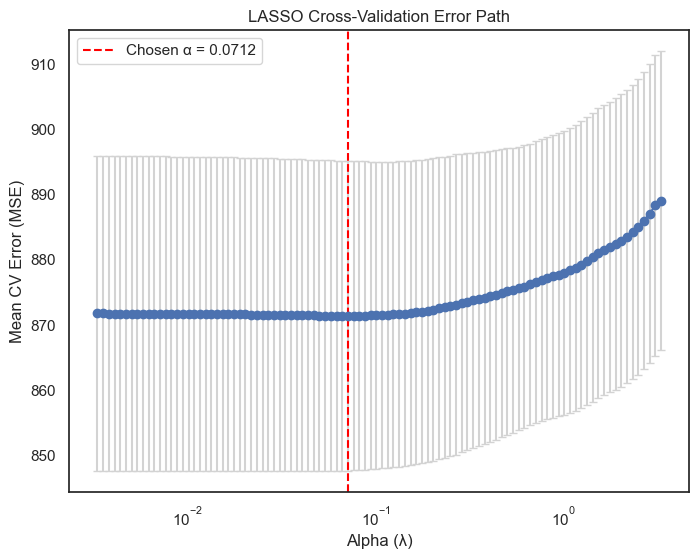

In [13]:
# LassoCV stores MSE values in lasso.mse_path_
# shape: (n_alphas, n_folds)
mse_mean = np.mean(lasso.mse_path_, axis=1)
mse_std = np.std(lasso.mse_path_, axis=1)

plt.figure(figsize=(8, 6))
plt.errorbar(lasso.alphas_, mse_mean, yerr=mse_std, fmt='o-', ecolor='lightgray', capsize=3)

plt.axvline(lasso.alpha_, color='red', linestyle='--', label=f"Chosen α = {lasso.alpha_:.4f}")
plt.xscale('log')
plt.xlabel("Alpha (λ)")
plt.ylabel("Mean CV Error (MSE)")
plt.title("LASSO Cross-Validation Error Path")
plt.legend()
plt.show()

In [17]:
import statsmodels.api as sm

# Restrict to selected predictors
X_post = X_expanded[selected.index]   # X_expanded is your patsy-expanded DataFrame
X_post = sm.add_constant(X_post)      # add intercept
y_post = response

post_lasso_model = sm.OLS(y_post, X_post).fit(cov_type="HC3")
print(f"Number of selected variables: {len(selected.index)}\n\n")
print(post_lasso_model.summary())

Number of selected variables: 28


                            OLS Regression Results                            
Dep. Variable:       dv_response_mean   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     16.60
Date:                Sat, 20 Sep 2025   Prob (F-statistic):           1.20e-79
Time:                        14:43:19   Log-Likelihood:                -99971.
No. Observations:               20819   AIC:                         2.000e+05
Df Residuals:                   20790   BIC:                         2.002e+05
Df Model:                          28                                         
Covariance Type:                  HC3                                         
                                                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------

In [18]:
# Extract coefficients, p-values, and standard errors
results_df = pd.DataFrame({
    "coef": post_lasso_model.params,
    "pval": post_lasso_model.pvalues,
    "se": post_lasso_model.bse
})

# Filter by p-value < 0.10 (ignore intercept)
filtered = results_df.loc[results_df.index != "const"]
filtered = filtered[filtered["pval"] < 0.10]

# Sort by absolute coefficient magnitude
filtered_sorted = filtered.reindex(filtered["coef"].abs().sort_values(ascending=False).index)

print("Significant variables (p < 0.10), sorted by effect size:\n")
print(filtered_sorted)


Significant variables (p < 0.10), sorted by effect size:

                                                         coef          pval  \
C(authority)[T.1.0]                                 10.414219  5.152608e-05   
C(ideo_affiliation)[T.Very liberal]                 -7.742084  1.423297e-30   
C(gender)[T.Prefer not to say]                      -6.668086  5.759377e-02   
C(central)[T.1.0]                                   -6.396192  6.999244e-06   
C(peripheral)[T.1.0]                                 4.087058  3.860266e-08   
C(gender)[T.Non-binary / third gender]              -3.795356  2.143040e-02   
C(ideo_affiliation)[T.Moderately liberal]           -2.815022  3.320428e-06   
C(partisanship)[T.1.0]                              -2.811302  3.929795e-04   
C(party_affiliation)[T.Other (Libertarian, Gree...  -2.806551  2.221226e-02   
C(religion)[T.1.0]                                  -2.233624  4.812721e-03   
C(gender)[T.Male]                                   -1.928608  5.560161e-

# 2. Embedding-based Analysis

From the previous section, it is evident that the linear fit based on these one-hot encoded variables led to a very poor linear fit (e.g. R^2 ~= 0.02!) So, now we wonder if we can include more complex information about `treatment_text` using word embedding models. 

## 2.1 Generate Word Embeddings and t-SNE Visualization

In [21]:
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
import plotly.express as px

EMBEDDER = "all-MiniLM-L6-v2"
encoder = SentenceTransformer(EMBEDDER)

def wrap_text(text, width=40):
    import textwrap
    return "<br>".join(textwrap.wrap(text, width=width))


Create a mapping between `treatment_message` and the `issue`

In [22]:
# create a dictionary of treatment message to issue stance 
msg_to_issue = {}
for _, row in merged_df.iterrows():
    # skip the na treatment messages
    if pd.isna(row['treatment_message']):
        continue
    msg_to_issue[row['treatment_message']] = row['issue_stance_full']

msgs = list(msg_to_issue.keys())
issues = list(set(msg_to_issue.values()))


Embed the `treatment_message`, which takes around 10 seconds

In [ ]:
msg_embeddings = encoder.encode(msgs)
msg_embeddings_tsne = TSNE(n_components=2, random_state=SEED).fit_transform(msg_embeddings)
# save the embeddings using numpy
np.save("msg_embeddings_tsne.npy", msg_embeddings_tsne)
np.save("msgs_word_embeddings.npy", msg_embeddings)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Observe that the embeddings of the response text are very well clustered by the issue that they correspond to (somewhat expected). 

In [24]:
fig = px.scatter(
    x=msg_embeddings_tsne[:, 0], 
    y=msg_embeddings_tsne[:, 1], 
    color=[msg_to_issue[m] for m in msgs],
    title="t-SNE Visualization of Treatment Messages by Issue Stance",
    labels={"color": "Issue Stance"},
    hover_data={"Message": [wrap_text(m, 60) for m in msgs]}
)
fig.write_html("treatment_messages_tsne.html")
fig.show()

Embed the `issue`, but since there are only 10 candidates, it is much less interesting.

In [29]:
from sklearn.decomposition import PCA

issue_embeddings = encoder.encode(issues)
issue_embeddings_pca = PCA(n_components=2, random_state=SEED).fit_transform(issue_embeddings)
# save the embeddings using numpy
np.save("issue_embeddings_pca.npy", issue_embeddings_pca)
np.save("issues_word_embeddings.npy", issue_embeddings)

In [33]:
fig = px.scatter(
    x=issue_embeddings_pca[:, 0],
    y=issue_embeddings_pca[:, 1],
    color=issues,
    title="PCA Visualization of Issues by Issue Stance",
    labels={"color": "Issue Stance"},
    hover_data={"Message": [wrap_text(issue, 60) for issue in issues]}
)
fig.write_html("issue_stances_pca.html")
fig.show()

### 2.1.2 Topical vs. Residual Embeddings

We now explore whether "decomposing" the embedding into a "topical" and "residual" component can reveal some different structure. 

In [ ]:
issue_assignments = np.array([issues.index(msg_to_issue[m]) for m in msgs])

# Step 1: build topic centroids
num_issues = issue_embeddings.shape[0]
topic_centroids = np.zeros((num_issues, 384))
for i in range(num_issues):
    topic_centroids[i] = msg_embeddings[issue_assignments == i].mean(axis=0)

# Step 2: PCA on centroids -> topical subspace
pca = PCA(n_components=min(num_issues, 50))
pca.fit(topic_centroids)
topic_axes = pca.components_.T  # (384, k)

# Step 3: project out topical subspace
proj = msg_embeddings @ topic_axes @ topic_axes.T
residual_embeddings = msg_embeddings - proj


Let us now learn PCA over the residual embeddings

In [45]:
residual_embeddings_tsne = TSNE(n_components=2, random_state=SEED).fit_transform(residual_embeddings)
# save the embeddings using numpy
np.save("residual_embeddings_tsne.npy", residual_embeddings_tsne)
np.save("residual_embeddings.npy", residual_embeddings)

Visualize the scatter plot using Plotly.

In [ ]:
msg_strategies = pd.read_csv("llm_responses_labeled.csv", index_col=0)
msg_strategies = msg_strategies.set_index('response').loc[msgs].reset_index()
msg_strategies.head()

,response,issue_stance_full,attractiveness,authority,central,forewarning,gainframe,lossframe,partisan,partisanship,peripheral,refutation,religion,repetition
0,"""For the sake of all humanity, I hereby procla...",The U.S. should allow terminally ill patients ...,1,1,1,1,1,1,0,0,0,0,0,0
1,The future of public workers in the United Sta...,The U.S. should transition pension plans for p...,1,1,1,1,1,1,1,0,0,0,0,0
2,Privatizing veteran healthcare is essential fo...,The U.S. should increase privatization of vete...,1,1,1,1,1,1,1,1,0,0,0,0
3,Affirmative action programs were initially int...,The U.S. should not allow the use of affirmati...,1,1,1,1,1,1,1,1,0,0,0,0
4,Foreign aid is a crucial aspect to maintain pe...,The U.S. should not decrease foreign aid spending,1,1,1,1,1,1,1,0,0,0,0,0


In [ ]:
fig = px.scatter(
    x=residual_embeddings_tsne[:, 0], 
    y=residual_embeddings_tsne[:, 1], 
    color=[msg_to_issue[m] for m in msgs],
    title="t-SNE Visualization of Treatment Messages by Issue Stance",
    labels={"color": "Issue Stance"},
    hover_data={"Message": [wrap_text(m, 60) for m in msgs]}
)
fig.write_html("residual_tsne.html")
fig.show()

In [57]:
# Build hover string listing all strategies
strategy_cols = ["attractiveness", "authority", "central", "forewarning",
                 "gainframe", "lossframe", "partisan", "partisanship",
                 "peripheral", "refutation", "religion", "repetition"]

def get_strategies(row):
    return ", ".join([col for col in strategy_cols if row[col] == 1])

msg_strategies["strategies_used"] = msg_strategies.apply(get_strategies, axis=1)

# Set custom color maps 
color_map = {
    "central": "orange",
    "peripheral": "blue",
    "both": "purple",
    "neither": "black"
}

# Create new column for strategy contrast
def strategy_contrast(row, strat1, strat2):
    if row[strat1] == 1 and row[strat2] == 0:
        return strat1
    elif row[strat1] == 0 and row[strat2] == 1:
        return strat2
    elif row[strat1] == 1 and row[strat2] == 1:
        return "both"
    else:
        return "neither"

def contrast_plot(strat1="central", strat2="peripheral"):
    # Recompute contrast column for chosen strategies
    msg_strategies["strategy_contrast"] = msg_strategies.apply(
        lambda row: strategy_contrast(row, strat1, strat2), axis=1
    )
    fig = px.scatter(
        x=residual_embeddings_tsne[:, 0],
        y=residual_embeddings_tsne[:, 1],
        color=msg_strategies["strategy_contrast"],
        title=f"t-SNE Visualization: ({strat1.capitalize()} vs {strat2.capitalize()})",
        labels={"color": "Strategies"},
        hover_data={
            "Message": [wrap_text(m, 200) for m in msg_strategies["response"]],
            "Strategies Used": msg_strategies["strategies_used"]
        },
        color_discrete_map=color_map
    )
    
    fig.write_html(f"strategies_scatter_plot/residual_tsne_{strat1}_vs_{strat2}.html")
    fig.show()


In [ ]:
contrast_plot("central", "peripheral")

## 2.2 How good can we predict persuasiveness from text embedding? 

In [9]:
# take the average value of "dv_response_mean" for each unique treatment message
agg_df = (
    merged_df
    .groupby("treatment_message", as_index=False)["dv_response_mean"]
    .mean()
    .rename(columns={"dv_response_mean": "avg_dv_response_mean"})
)
print(agg_df.shape) 
agg_df.head()


(730, 2)


,treatment_message,avg_dv_response_mean
0,"""America is known for its innovation and diver...",28.400000
1,"""As a global leader in the security industry, ...",66.166667
2,"""As an American citizen, I strongly believe th...",65.812500
3,"""Dear Senator,\n\nI am writing to urge you to ...",45.808824
4,"""For the sake of all humanity, I hereby procla...",72.300000


In [10]:
X = np.load("msgs_word_embeddings.npy")
y = agg_df['avg_dv_response_mean'].values
X.shape, y.shape

((730, 384), (730,))

In [11]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error
from scipy import stats

def evaluate_model(model, X, y, K=10, random_state=SEED):
    """
    Evaluate a regression model with K-fold cross-validation or repeated train/test splits.

    Parameters
    ----------
    model : sklearn estimator (regressor)
    X : np.ndarray, shape (n_samples, n_features)
    y : np.ndarray, shape (n_samples,)
    K : int, number of folds
    random_state : int, reproducibility
    
    Returns
    -------
    results : dict
        Dictionary containing mean R^2, mean RMSE, 95% CI for each.
    """
    r2_scores, rmse_scores = [], []
    
    kf = KFold(n_splits=K, shuffle=True, random_state=random_state)
    
    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        r2_scores.append(r2_score(y_test, y_pred))
        rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    
    def mean_ci(scores, alpha=0.05):
        mean = np.mean(scores)
        ci_low, ci_high = stats.t.interval(
            1 - alpha, len(scores) - 1, loc=mean, scale=stats.sem(scores)
        )
        return mean, (ci_low, ci_high)
    
    r2_mean, r2_ci = mean_ci(r2_scores)
    rmse_mean, rmse_ci = mean_ci(rmse_scores)
    
    return {
        "r2_mean": r2_mean,
        "r2_95ci": r2_ci,
        "rmse_mean": rmse_mean,
        "rmse_95ci": rmse_ci,
        "r2_all": r2_scores,
        "rmse_all": rmse_scores
    }


In [12]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.svm import SVR, LinearSVR
from sklearn.ensemble import RandomForestRegressor

models = {
    "Linear Regression": LinearRegression(),
    "Lasso (α=10)": Lasso(alpha=10),
    "Linear SVM": LinearSVR(C=1.0, max_iter=5000),
    "Kernel SVM (RBF)": SVR(kernel="rbf", C=1.0), 
    "Random Forest": RandomForestRegressor(n_estimators=20, random_state=SEED)
}

# Collect results
all_r2, all_rmse = [], []
for name, model in models.items():
    res = evaluate_model(model, X, y, K=5)
    
    for score in res["r2_all"]:
        all_r2.append({"Model": name, "Score": score})
    
    for score in res["rmse_all"]:
        all_rmse.append({"Model": name, "Score": score})

df_r2 = pd.DataFrame(all_r2)
df_rmse = pd.DataFrame(all_rmse)

In [14]:
df_rmse
df_rmse.to_csv("predictor_rmse.csv")

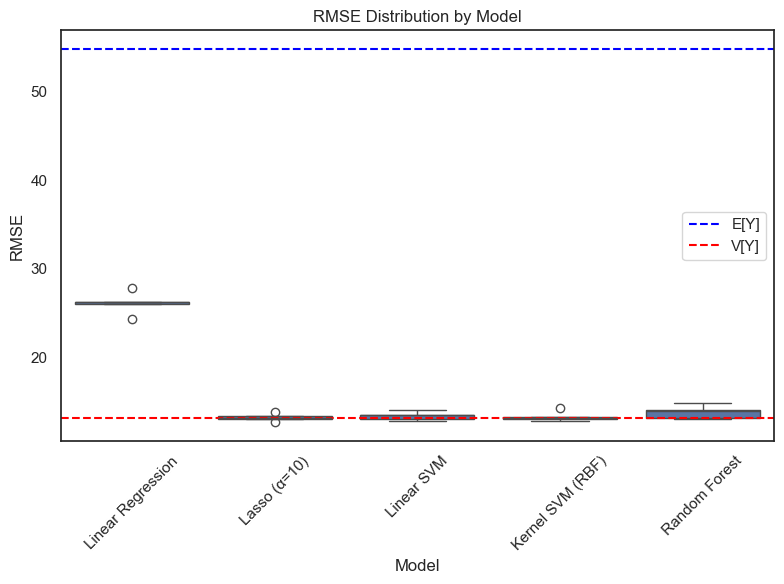

In [17]:
df_rmse = pd.read_csv("predictor_rmse.csv")

# Plot RMSE distributions
plt.figure(figsize=(8, 6))
sns.boxplot(x="Model", y="Score", data=df_rmse)
plt.title("RMSE Distribution by Model")
plt.ylabel("RMSE")
plt.xlabel("Model")
plt.xticks(rotation=45)
# plot horizontal baseline 
expectation_y = np.mean(y)
baseline_rmse = np.sqrt(np.mean((y - np.mean(y))**2))
plt.axhline(expectation_y, color='blue', linestyle='--', label='E[Y]')
plt.axhline(baseline_rmse, color='red', linestyle='--', label='V[Y]')
plt.legend()
plt.tight_layout()
plt.savefig("plot_rmse_prediction.png", dpi=200)


## 2.3 Sparse Autoencoder to generate hypothesis

In [6]:
from hypothesaes.quickstart import train_sae, generate_hypotheses

In [28]:
msgs = np.load("msgs.npy")

In [10]:
# take the average value of "dv_response_mean" for each unique treatment message
agg_df = (
    merged_df
    .groupby("treatment_message", as_index=False)["dv_response_mean"]
    .mean()
    .rename(columns={"dv_response_mean": "avg_dv_response_mean"})
)
agg_df.head()

X = np.load("msgs_word_embeddings.npy")
y = agg_df['avg_dv_response_mean'].values
X.shape, y.shape

((730, 384), (730,))

In [18]:
EMBEDDER = "all-MiniLM-L6-v2"
CACHE_NAME = f"persuasive_messages_{EMBEDDER}"
checkpoint_dir = os.path.join("checkpoints", CACHE_NAME)
# samples a random 80% of the data as training data, and the rest as validation data

np.random.seed(SEED)
train_embeddings = X[np.random.choice(X.shape[0], size=int(0.8 * X.shape[0]), replace=False)]
train_indices = np.array([np.where((X == emb).all(axis=1))[0][0] for emb in train_embeddings])
val_embeddings = X[np.setdiff1d(np.arange(X.shape[0]), train_indices)]

sae = train_sae(embeddings=train_embeddings, val_embeddings=val_embeddings,
                M=128, K=8, matryoshka_prefix_lengths=[32, 128], 
                checkpoint_dir=checkpoint_dir)

  0%|          | 0/100 [00:00<?, ?it/s]

Saved model to checkpoints/persuasive_messages_all-MiniLM-L6-v2/SAE_matryoshka_M=128_K=8_prefixes=32-128.pt


In [19]:
INTERPRETER_MODEL = "gpt-4.1"
ANNOTATOR_MODEL = "gpt-4.1-mini"
N_WORKERS_ANNOTATION = 4

TASK_SPECIFIC_INSTRUCTIONS = """All of the texts are messages attempting to persuade someone on a particular issue stance.
Features should describe a specific aspect of the persuasion message. For example:
- "appeals to the reader's sense of patriotism"
- "uses emotional language to evoke sympathy"
- "employs logical arguments supported by data"
- "cites evidence from research articles published by MIT"
- "argues on the basis of Christian values"
- "warns the readers about potential counterarguments"
- "mentions the imminent threat of climate change"
- "cites a study mentioned in the New York Times'\""""

In [31]:
from dotenv import load_dotenv
load_dotenv() # need to use OPENAI_KEY_SAE in .env file

True

The below code requires having an OpenAI API key (although you can do without if you dive into the HypotheSAEs codebase). It takes around 5 minutes to run and costs about 13 cents. 

In [32]:
selection_method = "lasso"
results = generate_hypotheses(
    texts=msgs,
    labels=y,
    embeddings=X,
    sae=sae,
    cache_name=CACHE_NAME,
    selection_method=selection_method,
    n_selected_neurons=20,
    n_candidate_interpretations=1,
    task_specific_instructions=TASK_SPECIFIC_INSTRUCTIONS,
    interpreter_model=INTERPRETER_MODEL,
    annotator_model=ANNOTATOR_MODEL,
    n_workers_annotation=N_WORKERS_ANNOTATION, # Please lower this parameter if you are running into OpenAI API rate limits
)

print("\nMost predictive features of message persuasion:")
pd.set_option('display.max_colwidth', None)
display(results.sort_values(by=f"target_{selection_method}", ascending=False).round(3))
pd.reset_option('display.max_colwidth')

Embeddings shape: (730, 384)


Computing activations (batchsize=16384):   0%|          | 0/1 [00:00<?, ?it/s]

Activations shape: (730, 128)

Step 1: Selecting top 20 predictive neurons
LASSO iteration   L1 Alpha # Features   Time (s)
----------------------------------------
       0   1.00e-01         89       0.01
       1   3.16e+01          0       0.00
       2   1.78e+00          0       0.00
       3   4.22e-01         28       0.00
       4   8.66e-01          4       0.00
       5   6.04e-01         16       0.00
       6   5.05e-01         23       0.00
       7   5.52e-01         18       0.00
       8   5.28e-01         21       0.00
       9   5.40e-01         19       0.00
      10   5.34e-01         21       0.00
      11   5.37e-01         20       0.00

Found alpha=5.37e-01 yielding exactly 20 features
Total search time: 0.02s

Step 2: Interpreting selected neurons
[WARNING] Only found 7 examples with positive activation, using all available
[WARNING] Only found 6 examples with positive activation, using all available
[WARNING] Only found 8 examples with positive activation, us

Generating interpretations:   0%|          | 0/20 [00:00<?, ?it/s]

API error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4.1 in organization org-8lBaBCFF6C20yE7E1yHv30BG on tokens per min (TPM): Limit 30000, Used 26990, Requested 4447. Please try again in 2.874s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}}; retrying in 20.0s... (2/3)
API error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4.1 in organization org-8lBaBCFF6C20yE7E1yHv30BG on tokens per min (TPM): Limit 30000, Used 25386, Requested 6271. Please try again in 3.314s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}}; retrying in 20.0s... (2/3)
API error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4.1 in organization org-8lBaBCFF6C20yE7E1yHv30BG on tokens per min (TPM): Limit 30000, Used 29012, Requested 6057. Please try again in 10.138s. Visit

Scoring neuron interpretation fidelity (20 neurons; 1 candidate interps per neuron; 100 examples to score each…


Most predictive features of message persuasion:


,neuron_idx,source_sae,target_lasso,interpretation,f1_fidelity_score
0,32,"(SAE_0, 128, 8)",0.719,"calls for the U.S. government to implement or maintain specific national policies, requirements, or programs (e.g., foreign aid, work requirements for Medicaid, national networks, compliance with regulations) as a means to achieve societal or national objectives",0.392
1,74,"(SAE_0, 128, 8)",0.702,argues in favor of increasing privatization of veteran healthcare in the United States,0.897
5,89,"(SAE_0, 128, 8)",0.288,argues that the U.S. electoral college system undermines the principle that every citizen's vote should have equal weight by enabling a candidate to win the presidency without winning the national popular vote,0.897
6,77,"(SAE_0, 128, 8)",0.232,discusses the psychological and developmental harms of solitary confinement on juvenile prisoners,0.601
7,55,"(SAE_0, 128, 8)",0.225,"discusses the right of individuals (such as terminally ill patients) to make autonomous decisions about their own lives, especially regarding end-of-life choices like assisted suicide",0.685
9,48,"(SAE_0, 128, 8)",0.176,"argues that increasing border restrictions is necessary to prevent crime, illegal immigration, or drug trafficking at the U.S. border",0.495
11,101,"(SAE_0, 128, 8)",0.146,"argues that solitary confinement for juveniles can serve as a tool for protection, prevention of harm, and rehabilitation within the juvenile justice system",0.990
12,105,"(SAE_0, 128, 8)",0.140,"explicitly references or appeals to the role, responsibilities, or fundamental rights of citizens within the context of U.S. democracy or government",0.533
19,47,"(SAE_0, 128, 8)",0.003,"frames the argument in terms of individual rights and human dignity, emphasizing protection of vulnerable groups from inhumane or discriminatory treatment",0.672
18,115,"(SAE_0, 128, 8)",-0.009,None,0.000


In [33]:
results.to_csv(f"persuasion_hypotheses_{selection_method}.csv")

In [34]:
results.head()

,neuron_idx,source_sae,target_lasso,interpretation,f1_fidelity_score
0,32,"(SAE_0, 128, 8)",0.719012,calls for the U.S. government to implement or ...,0.392453
1,74,"(SAE_0, 128, 8)",0.701764,argues in favor of increasing privatization of...,0.896661
2,121,"(SAE_0, 128, 8)",-0.529743,argues that denying voting rights to convicted...,0.529412
3,122,"(SAE_0, 128, 8)",-0.334592,argues for reform or improvement of an existin...,0.609137
4,51,"(SAE_0, 128, 8)",-0.307649,argues that denying convicted felons the right...,0.944024
